In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os
import string
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from typing import * 


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, Subset, DataLoader

import torchvision.transforms as VT


# from craft.datasets import utils
# from craft.models import crnn_v1

# import craft.transforms as NT
# from craft.data.dataset import LMDBDataset, BalanceDatasetConcatenator
# from craft.utils import AttnLabelConverter

In [542]:
import json
import random
from pathlib import Path

import cv2 as cv
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

# from craft_iqra import utils
from typing import *

from craft.ops import boxes, box_ops, affinity, synthtext
from craft.ops.gaussian import GaussianGenerator
from craft.datasets import utils

from tqdm.notebook import tqdm

class CustomDataset(Dataset):
    def __init__(self, root, mode='train', transform=None, split_val=0.2, scale_size=0.5,
                 gauss_ksize=(50, 50), gauss_dratio=3.0, gauss_use_pad=False, gauss_pad_factor=0.1,
                 aff_thresh=0.01, image_ext='jpg', **kwargs):
        self.root = Path(root)
        self.mode = mode
        self.split_val = split_val
        self.transform = transform
        self.scale_size = scale_size
        self.image_ext = image_ext
        self.gaussian = GaussianGenerator(ksize=gauss_ksize, dratio=gauss_dratio,
                                          use_pad=gauss_use_pad, pad_factor=gauss_pad_factor)

        self.aff_threshold = aff_thresh
        self.image_files = []
        self.json_files = []
        self._load_files()
        self._split_dataset()


    def _load_files(self):
        base_path = self.root
        index_file = base_path.joinpath('indexmap.csv')
        if not index_file.exists():
            raise FileNotFoundError(
                "indexmap.csv is not found in root directory, make sure the file is exist before we can coninue to load the data!")
        df = pd.read_csv(index_file)
        
        self.image_files = df['image_file']
        self.json_files = df['json_file']

#         error_index = []
#         for index, data in tqdm(df.iterrows()):
#             image = base_path.joinpath(data['image_file'])
#             json = base_path.joinpath(data['json_file'])
#             if not (image.exists() and json.exists()):
#                 error_index.append(index)
#             else:
#                 self.image_files.append(image)
#                 self.json_files.append(json)

#         if len(error_index) > 0:
#             raise FileNotFoundError(
#                 f"File in indexmap with number {error_index} is not found, please fix the file before we can continue to load the data!")

    def _split_dataset(self):
        random.seed(1618)
        len_files = len(self.image_files)
        index_list = [i for i in range(len_files)]

        valid_total = int(round(self.split_val * len_files))
        valid_index_list = sorted(random.sample(index_list, valid_total))
        train_index_list = sorted(list(set(index_list).difference(set(valid_index_list))))

        if self.mode == 'train':
            self.image_files = [self.image_files[x] for x in train_index_list]
            self.json_files = [self.json_files[x] for x in train_index_list]
        elif self.mode == 'valid':
            self.image_files = [self.image_files[x] for x in valid_index_list]
            self.json_files = [self.json_files[x] for x in valid_index_list]

    def _get_image(self, idx):
        impath = str(self.image_files[idx])
        impath = str(self.root.joinpath(impath))
        print(impath)
        return utils.load_image(impath)

    def _load_json_to_dict(self, idx):
        path = str(self.json_files[idx])
        path = str(self.root.joinpath(path))
        return utils.load_json2dict(path)

    def _extract_json_file(self, idx):
        data = self._load_json_to_dict(idx)
        char_dict = []
        word_dict = []
        for dct in data['objects']:
            if dct['text']!="":
                word_dict.append(dct)
                for cdct in dct['chardata']:
                    char_dict.append(cdct)
        return data['image'], char_dict, word_dict

    def _convert_dict_to_bbox(self, data_dict):
        values = []
        bbox = []
        for dct in data_dict:
            box = np.array(dct['points'])
            box = box_ops.order_points(box)
            bbox.append(box)
        bbox = np.array(bbox)
        return bbox, values

    def _get_region_score_image(self, image: np.ndarray, charbb: List):
        h, w = image.shape[0], image.shape[1]
        region_boxes = sorted(charbb.tolist())
        region_score = self.gaussian(boxes=region_boxes, image_size=(h, w))
        return region_score

    def _get_affinity_score_image(self, image: np.ndarray, charbb: List, wordbb: List):
        h, w = image.shape[0], image.shape[1]
        affinity_boxes = affinity.boxes(wordbb, charbb, threshold=self.aff_threshold)
        afscore = self.gaussian(affinity_boxes, image_size=(h, w))
        return afscore, torch.from_numpy(np.array(affinity_boxes))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self._get_image(idx)

        image_dict, char_dict, word_dict = self._extract_json_file(idx)
        charbb, char_val = self._convert_dict_to_bbox(char_dict)
        wordbb, word_val = self._convert_dict_to_bbox(word_dict)

        region_score = self._get_region_score_image(image, charbb)
#         region_score = None
        affinity_score, affinity_boxes = self._get_affinity_score_image(image, charbb, wordbb)

        if self.transform:
            image, region_score, affinity_score = self.transform(image, region_score, affinity_score)

        charbb, wordbb = torch.Tensor(charbb).permute(2, 1, 0), torch.Tensor(wordbb).permute(2, 1, 0)
        # return image, region_score, affinity_score, charbb, wordbb, affinity_boxes
        # return image, region_score, affinity_score, charbb, char_val, wordbb, word_val
        # print(charbb.shape, wordbb.shape)
        # return image, region_score, affinity_score, charbb, wordbb

        return image, region_score, affinity_score

    def get(self, idx):
        impath = self.image_files[idx]
        image = self._get_image(idx)

        image_dict, char_dict, word_dict = self._extract_json_file(idx)
        charbb, char_val = self._convert_dict_to_bbox(char_dict)
        wordbb, word_val = self._convert_dict_to_bbox(word_dict)

        region_score = self._get_region_score_image(image, charbb)
        affinity_score, affinity_boxes = self._get_affinity_score_image(image, charbb, wordbb)

        if self.transform:
            t_image, t_region_score, t_affinity_score = self.transform(image, region_score, affinity_score)

        # charbb, wordbb = torch.Tensor(charbb), torch.Tensor(wordbb)
        return impath, image, t_image, region_score, t_region_score, affinity_score, t_affinity_score, charbb, wordbb, word_val

    def get_word(self, idx):
        impath = self.image_files[idx]
        image = self._get_image(idx)

        image_dict, char_dict, word_dict = self._extract_json_file(idx)
        wordbb, word_val = self._convert_dict_to_bbox(word_dict)

        return impath, image, wordbb, word_val

In [551]:
%%time
path = '/workspace/serverfs/data/idcard/combined/tester3'
dataset = CustomDataset(root=path)

CPU times: user 73.8 ms, sys: 366 µs, total: 74.1 ms
Wall time: 73 ms


In [589]:
data = dataset[4]

/workspace/serverfs/data/idcard/combined/tester3/121191_image.jpg


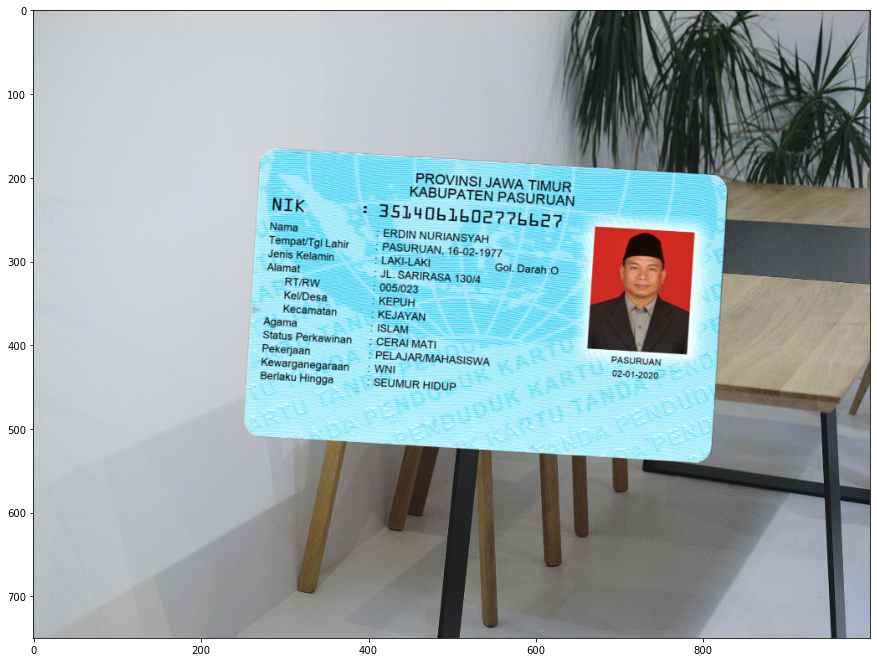

In [590]:
plt.figure(figsize=(15,15))
plt.imshow(data[0])

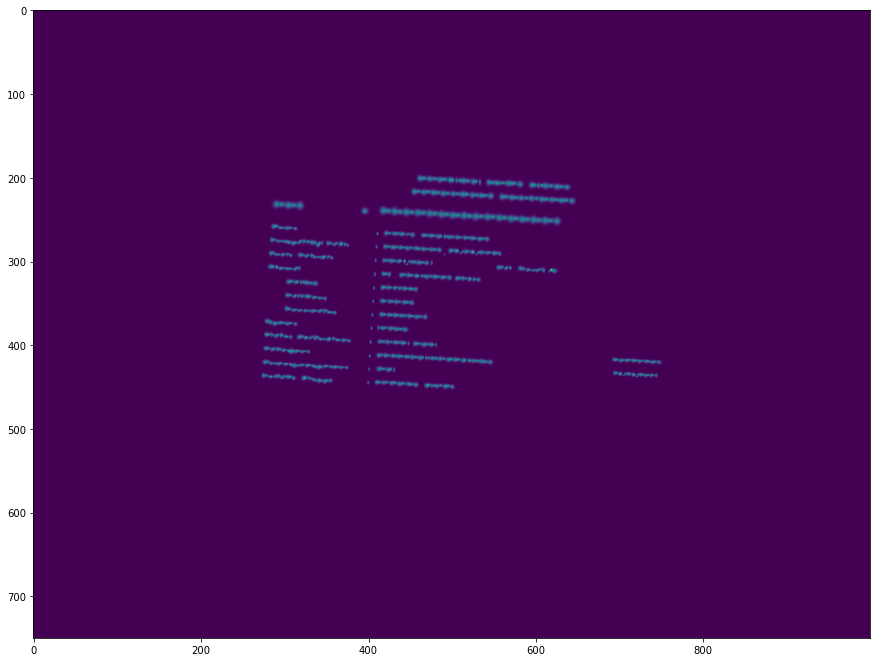

In [591]:
plt.figure(figsize=(15,15))
plt.imshow(data[2]+data[1])

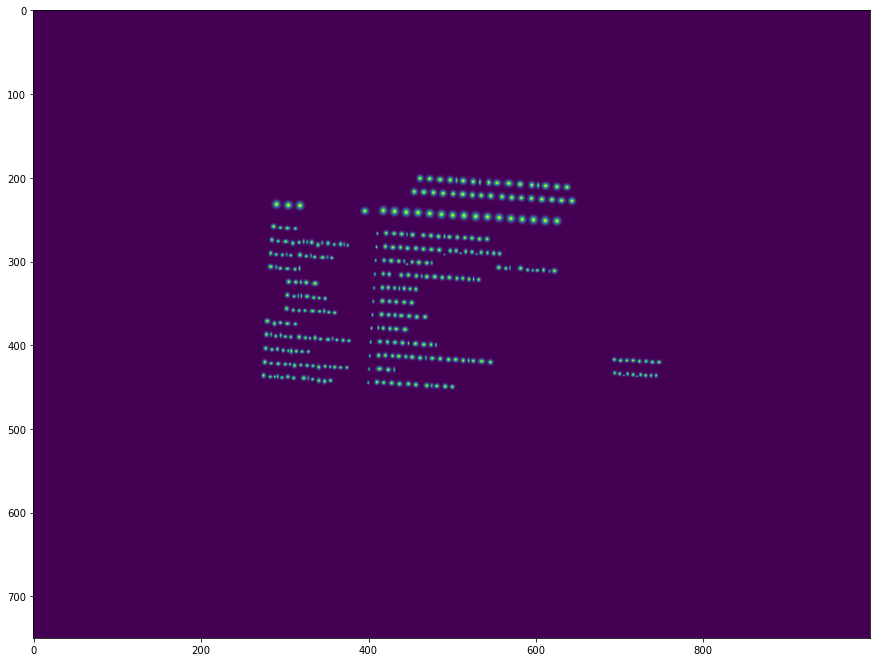

In [592]:
plt.figure(figsize=(15,15))
plt.imshow(data[1])

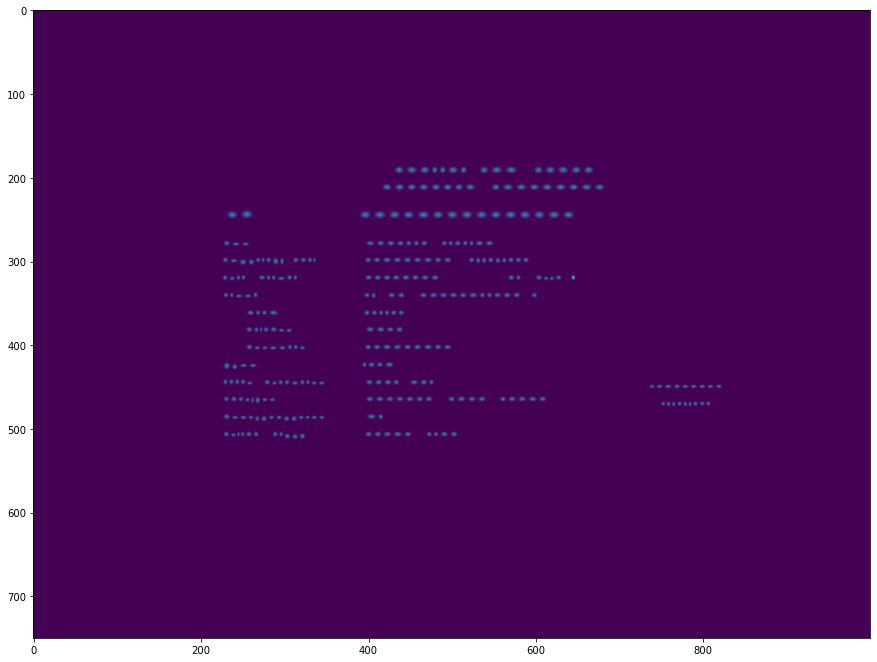

In [588]:
plt.figure(figsize=(15,15))
plt.imshow(data[2])

In [243]:
from pathlib import Path
import pandas as pd

path = '/workspace/serverfs/data/idcard/combined/word_char_v1/'
base_path = Path(path)

In [191]:
df = pd.read_csv(str(base_path.joinpath('indexmap.csv')))

In [231]:
idx = 12
imfile = df.iloc[idx]['image_file']
jsfile = df.iloc[idx]['json_file']

impath = base_path.joinpath(imfile)
jspath = base_path.joinpath(jsfile)

In [232]:
import cv2 as cv
img = utils.load_image(str(impath))
jsdict = utils.load_json2dict(str(jspath))

In [338]:
points = jsdict['objects'][1]['points']

for dct in jsdict['objects']:
    points = dct['points']
    points = np.array(points).astype(np.int32)
    xymm = boxes.coord2xymm(points, to_int=True)
#     start_point = (xymm[0],xymm[1])
#     end_point = (xymm[2],xymm[3])
    color = (255, 0, 0) 
    thickness = 2
    is_closed = True
    img = cv.polylines(img, [points], is_closed, color, thickness) 
    
    for cdct in dct['chardata']:
        cpoints = cdct['points']
#         print(cpoints)
        cpoints = np.array(cpoints).astype(np.int32)
        cpoints = box_ops.order_points(cpoints)
        xymm = boxes.coord2xymm(cpoints, to_int=True)
#         print(xymm)
        start_point = (xymm[0],xymm[1])
        end_point = (xymm[2],xymm[3])
        color = (0, 255, 0) 
        thickness = 2
        is_closed = True
#         img = cv.polylines(img, [cpoints], is_closed, color, thickness) 
        img = cv.rectangle(img, start_point, end_point, color, thickness)        
#     print()
    


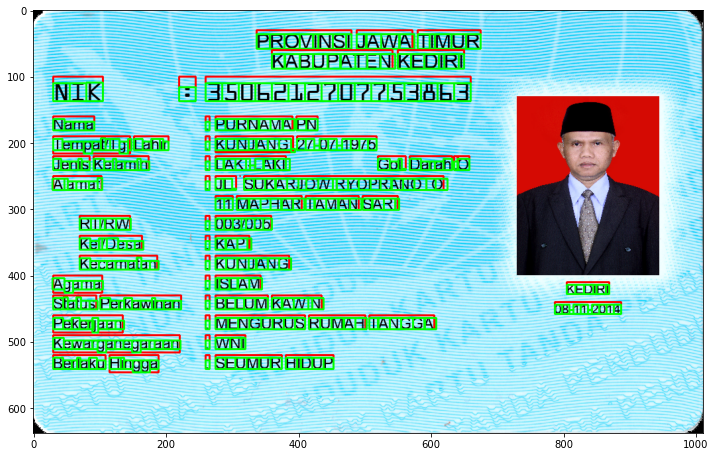

In [339]:
plt.figure(figsize=(12,12))
plt.imshow(img)

In [340]:
from pathlib import Path
import pandas as pd

path = '/workspace/serverfs/data/idcard/base_100k_v4/'
base_path = Path(path)
image_files = base_path.glob("*.png")
image_files = sorted(image_files)
json_files = base_path.glob("*.json")
json_files = sorted(json_files)

In [341]:
idx = 10
impath = str(image_files[idx])
jspath = str(json_files[idx])
impath, jspath

('/workspace/serverfs/data/idcard/base_100k_v4/3202211402019499_26802.png',
 '/workspace/serverfs/data/idcard/base_100k_v4/3202211402019499_26802.json')

In [342]:
import cv2 as cv
img = utils.load_image(str(impath))
jsdict = utils.load_json2dict(str(jspath))

In [343]:
# points = jsdict['objects'][1]['points']
c=0
for dct in jsdict['objects']:
    points = dct['points']
    points = np.array(points).astype(np.int32)
    xymm = boxes.coord2xymm(points, to_int=True)
    start_point = (xymm[0],xymm[1])
    end_point = (xymm[2],xymm[3])
    color = (255, 0, 0) 
    thickness = 2
    is_closed = True
#     img = cv.polylines(img, [points], is_closed, color, thickness) 
    img = cv.rectangle(img, start_point, end_point, color, thickness)        
    
#     if c<5:
    for cdct in dct['chardata']:
        cpoints = cdct['points']
#         print(cpoints)
        cpoints = np.array(cpoints).astype(np.int32)
#         print(cpoints.shape)
#         print(cpoints)
#         cpoints = box_ops.order_points(cpoints)

        xymm = boxes.coord2xymm(cpoints)
#         print(xymm)
        c_start_point = (xymm[0],xymm[1])
        c_end_point = (xymm[2],xymm[3])
        color = (0, 255, 0) 
        thickness = 1
        is_closed = True
#         img = cv.polylines(img, [cpoints], is_closed, color, thickness) 
        img = cv.rectangle(img, c_start_point, c_end_point, color, thickness)        
#     print()

    c=c+1
    


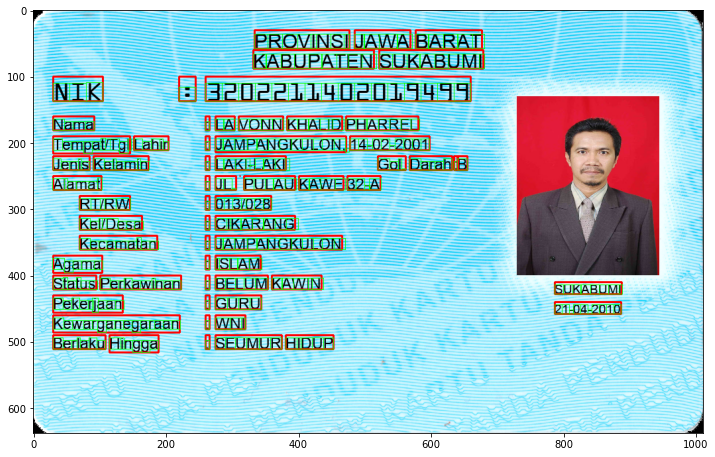

In [344]:
plt.figure(figsize=(12,12))
plt.imshow(img)